In [ ]:
pip install --upgrade category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder 
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from category_encoders import OrdinalEncoder
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.impute import SimpleImputer

In [ ]:
df = pd.read_csv("/content/Seoul_Market.csv", encoding='euc-kr', engine = 'python')
#데이터 불러오기

In [ ]:
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34542 entries, 0 to 34541
Data columns (total 81 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   기준_년_코드          34542 non-null  int64  
 1   기준_분기_코드         34542 non-null  int64  
 2   상권_구분_코드         34542 non-null  object 
 3   상권_구분_코드_명       34542 non-null  object 
 4   상권_코드            34542 non-null  int64  
 5   상권_코드_명          34542 non-null  object 
 6   서비스_업종_코드        34542 non-null  object 
 7   서비스_업종_코드_명      34542 non-null  object 
 8   분기당_매출_금액        34542 non-null  float64
 9   분기당_매출_건수        34542 non-null  int64  
 10  주중_매출_비율         34542 non-null  int64  
 11  주말_매출_비율         34542 non-null  int64  
 12  월요일_매출_비율        34542 non-null  int64  
 13  화요일_매출_비율        34542 non-null  int64  
 14  수요일_매출_비율        34542 non-null  int64  
 15  목요일_매출_비율        34542 non-null  int64  
 16  금요일_매출_비율        34542 non-null  int64  
 17  토요일_매출_비율   

In [ ]:
#외식업 데이터만 정리
df_1=df[df.서비스_업종_코드_명.isin(['한식음식점', '커피-음료', '분식전문점', '호프-간이주점',
      '치킨전문점', '중식음식점','패스트푸드점', '일식음식점', '양식음식점'])].reset_index(drop = True)

In [ ]:
import matplotlib.font_manager as fm
font = fm.FontProperties(fname='../input/korea-corona-case-to-211227/malgun.ttf')

#폰트 정리하려고 했으나 적용 안됨

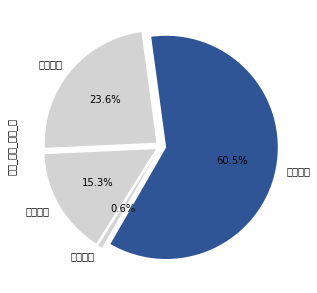

In [ ]:
colors = ['#2F5597', 'lightgray', 'lightgray', 'lightgray']
explode = [0.05, 0.05, 0.05, 0.05]
df_1['상권_구분_코드_명'].value_counts(normalize = True).plot(kind = 'pie', colors = colors, autopct='%.1f%%', startangle=240, explode = explode, counterclock=True, figsize = (5, 7));

#서울시 상권 비율, 골목상권은 전체 1596개중 1057개 차지, 골목상권, 전통시장, 발달상권, 관광특구 순

In [ ]:
df_1['상권_구분_코드_명'].value_counts()

골목상권    5043
발달상권    1967
전통시장    1277
관광특구      52
Name: 상권_구분_코드_명, dtype: int64

In [ ]:
colors = ['#2F5597', 'lightgray', 'lightgray', 'lightgray']
explode = [0.05, 0.05, 0.05, 0.05]
df_1.groupby('상권_구분_코드_명')['상권_코드_명'].nunique()

상권_구분_코드_명
골목상권    1057
관광특구       6
발달상권     248
전통시장     285
Name: 상권_코드_명, dtype: int64

In [ ]:
df_1.groupby('상권_구분_코드_명').sum()['점포수'].sort_values(ascending = False)

상권_구분_코드_명
발달상권    58682
골목상권    40906
전통시장    12648
관광특구     4604
Name: 점포수, dtype: int64

In [ ]:
df_1[df_1['상권_구분_코드_명'] == '골목상권']['서비스_업종_코드_명'].value_counts().sort_values(ascending = False)

한식음식점      995
커피-음료      796
호프-간이주점    684
분식전문점      671
치킨전문점      544
중식음식점      513
패스트푸드점     378
일식음식점      258
양식음식점      204
Name: 서비스_업종_코드_명, dtype: int64

In [ ]:
df1_2=df_1.groupby('상권_구분_코드_명').sum()['분기당_매출_금액'].sort_values(ascending = False).to_frame()
df1_2['상권수'] = df_1.groupby('상권_구분_코드_명')['상권_코드_명'].nunique()
df1_2['상권별평균매출'] = df1_2['분기당_매출_금액']/df1_2['상권수']
df1_2['상권별점포수'] = df_1.groupby('상권_구분_코드_명').sum()['점포수']
df1_2['상권별점포당평균매출'] = df1_2['분기당_매출_금액'] /df1_2['상권별점포수']
df1_2['상권별평균점포수'] = df1_2['상권별점포수']/df1_2['상권수']
df1_2['상권별점포당평균매출'].sort_values()

#특성 추가 - 상권 점포당 평균 매출

상권_구분_코드_명
골목상권    2.799628e+07
전통시장    3.808277e+07
발달상권    5.055463e+07
관광특구    5.708014e+07
Name: 상권별점포당평균매출, dtype: float64

In [ ]:
df1_2

,분기당_매출_금액,상권수,상권별평균매출,상권별점포수,상권별점포당평균매출,상권별평균점포수
상권_구분_코드_명,,,,,,
발달상권,2.966647e+12,248,1.196229e+10,58682,5.055463e+07,236.620968
골목상권,1.145216e+12,1057,1.083459e+09,40906,2.799628e+07,38.700095
전통시장,4.816709e+11,285,1.690073e+09,12648,3.808277e+07,44.378947
관광특구,2.627970e+11,6,4.379950e+10,4604,5.708014e+07,767.333333


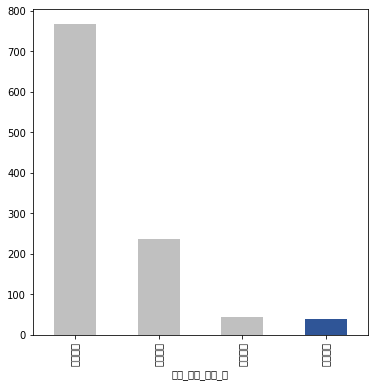

In [ ]:
df1_2['상권별평균점포수'].sort_values(ascending = False).plot(kind='bar', color=['silver', 'silver', 'silver','#2F5597'], figsize = (6, 6));

#골목 상권 평균 점포수는 38.7개
#관광특구, 발달상권, 전통시장, 골목상권 순

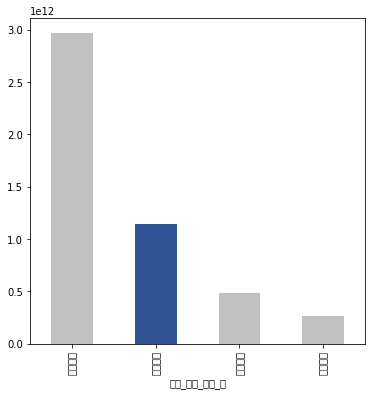

In [ ]:
df1_2['분기당_매출_금액'].sort_values(ascending = False).plot(kind='bar', color=['silver', '#2F5597','silver', 'silver'], figsize = (6, 6));

#골목상권  1/4분기 총 매출- 1조 1,445억
#발달상권, 골목상권, 전통시장, 관광특구 순

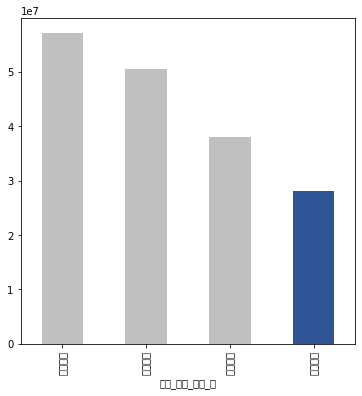

In [ ]:
df1_2['상권별점포당평균매출'].sort_values(ascending = False).plot(kind='bar', color=['silver', 'silver', 'silver','#2F5597'], figsize = (6, 6));

#점포당 평균 분기 매출 - 평균 2,740 만원
#관광특구, 발달상권, 전통시장, 골목상권 순

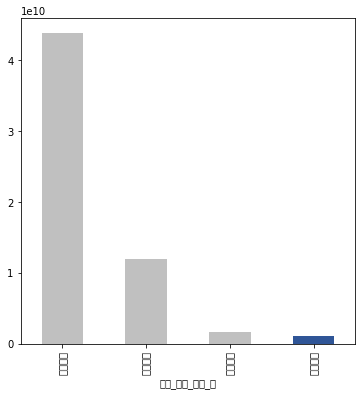

In [ ]:
df1_2['상권별평균매출'].sort_values(ascending = False).plot(kind='bar', color=['silver', 'silver', 'silver','#2F5597'], figsize = (6, 6));

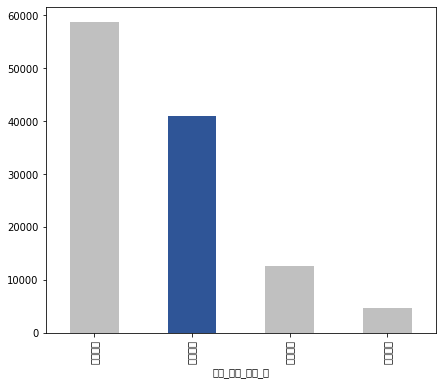

In [ ]:
df_1.groupby('상권_구분_코드_명').sum()['점포수'].sort_values(ascending = False).plot(kind = 'bar', color=['silver', '#2F5597', 'silver', 'silver'], figsize = (7, 6));

#골목상권 점포 수 – 40,906개 (전체 116,840개)
#발달상권, 골목상권, 전통시장, 관광특구 순

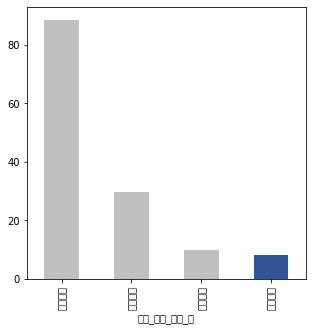

In [ ]:
df_1_1 = df_1.groupby('상권_구분_코드_명').sum()['점포수'].to_frame()
df_1_1['상권수'] = df_1['상권_구분_코드_명'].value_counts()
df_1_1['평균점포수'] = df_1_1['점포수']/df_1_1['상권수']
df_1_1['평균점포수'].sort_values(ascending = False).plot(kind = 'bar', color = ['silver', 'silver', 'silver', '#2F5597'], figsize = (5,5
                                                                                                                            ))

In [ ]:
df1_3 = df_1.groupby(['상권_구분_코드_명', '서비스_업종_코드_명']).sum()['점포수'].to_frame()

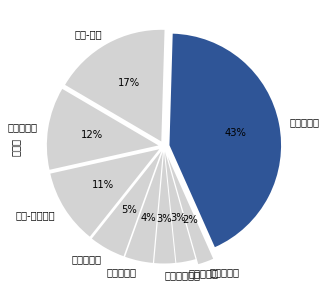

In [ ]:
dfstreet = df_1[df_1['상권_구분_코드_명'] == '골목상권']
explode = [0.1, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05]
dfstreet.groupby('서비스_업종_코드_명').sum()['점포수'].sort_values(ascending = True).plot(kind = 'pie', autopct='%.f%%', startangle=294, explode = explode, colors = ('lightgray','lightgray', 'lightgray', 'lightgray', 'lightgray', 'lightgray',  'lightgray',  'lightgray', '#2F5597'),counterclock=False, figsize = (5, 7));
#골목상권 업종별 분포
#한식음식점, 커피-음료, 분식전문점, 호프-간이주점, 치킨전문점, 중식음식점, 패스트푸드점, 양식음식점, 일식음식점 순

In [ ]:
df_1['점포당_평균_매출'] = df_1['분기당_매출_금액']/df_1['점포수']
df_1['평균도달여부'] = ["1" if i >= df_1['점포당_평균_매출'].mean() else "0" for i in df_1['점포당_평균_매출']]

#점포당 평균 매출 특성 추가
#특성의 평균도달 여부를 다시 정리해서 특성 추가

In [ ]:
df_1['점포당_평균_매출'] 

0       5.052296e+07
1       2.538542e+08
2       1.088688e+08
3       7.507100e+07
4       1.805877e+08
            ...     
8334    4.335651e+07
8335    1.046576e+07
8336    5.119924e+06
8337    3.080667e+07
8338    6.198273e+07
Name: 점포당_평균_매출, Length: 8339, dtype: float64

In [ ]:
dels = [col for col in df_1.columns if ("매출_건수" in col or "매출_금액" in col)]
df1_clean = df_1.drop(columns = dels)
df1_clean['분기당_매출_금액'] = df_1['분기당_매출_금액']
cols = ["기준_년_코드", "기준_분기_코드", "상권_구분_코드", "서비스_업종_코드"]
df1_clean = df1_clean.drop(columns = cols)
df1_clean

,상권_구분_코드_명,상권_코드,상권_코드_명,서비스_업종_코드_명,주중_매출_비율,주말_매출_비율,월요일_매출_비율,화요일_매출_비율,수요일_매출_비율,목요일_매출_비율,...,연령대_20_매출_비율,연령대_30_매출_비율,연령대_40_매출_비율,연령대_50_매출_비율,연령대_60_이상_매출_비율,점포수,평균,점포당_평균_매출,평균도달여부,분기당_매출_금액
0,관광특구,1001496,강남 마이스 관광특구,커피-음료,71,29,13,13,14,16,...,27,38,20,10,5,52,NaN,5.052296e+07,1,2.627194e+09
1,관광특구,1001496,강남 마이스 관광특구,분식전문점,64,37,8,8,17,15,...,26,40,17,11,6,29,NaN,2.538542e+08,1,7.361772e+09
2,관광특구,1001496,강남 마이스 관광특구,패스트푸드점,68,32,12,12,14,15,...,31,35,19,9,5,14,NaN,1.088688e+08,1,1.524163e+09
3,관광특구,1001496,강남 마이스 관광특구,양식음식점,65,35,12,12,14,13,...,26,36,22,12,5,35,NaN,7.507100e+07,1,2.627485e+09
4,관광특구,1001496,강남 마이스 관광특구,일식음식점,67,33,12,13,14,14,...,28,32,19,12,8,20,NaN,1.805877e+08,1,3.611754e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8334,골목상권,2110002,독립문역 1번,한식음식점,77,23,16,13,16,16,...,6,11,17,30,36,8,NaN,4.335651e+07,1,3.468521e+08
8335,골목상권,2110001,이북5도청사,커피-음료,67,33,10,13,16,15,...,19,16,20,31,15,2,NaN,1.046576e+07,0,2.093152e+07
8336,골목상권,2110001,이북5도청사,호프-간이주점,40,60,15,17,0,0,...,0,19,9,35,38,1,NaN,5.119924e+06,0,5.119924e+06
8337,골목상권,2110001,이북5도청사,분식전문점,49,52,8,9,12,9,...,3,11,25,33,29,3,NaN,3.080667e+07,0,9.242002e+07


In [ ]:
df1_clean.columns

Index(['상권_구분_코드_명', '상권_코드', '상권_코드_명', '서비스_업종_코드_명', '주중_매출_비율', '주말_매출_비율',
       '월요일_매출_비율', '화요일_매출_비율', '수요일_매출_비율', '목요일_매출_비율', '금요일_매출_비율',
       '토요일_매출_비율', '일요일_매출_비율', '시간대_00~06_매출_비율', '시간대_06~11_매출_비율',
       '시간대_11~14_매출_비율', '시간대_14~17_매출_비율', '시간대_17~21_매출_비율',
       '시간대_21~24_매출_비율', '남성_매출_비율', '여성_매출_비율', '연령대_10_매출_비율',
       '연령대_20_매출_비율', '연령대_30_매출_비율', '연령대_40_매출_비율', '연령대_50_매출_비율',
       '연령대_60_이상_매출_비율', '점포수', '평균', '점포당_평균_매출', '평균도달여부', '분기당_매출_금액'],
      dtype='object')

In [ ]:
df2 = pd.read_csv("/content/직장인구.csv", encoding='euc-kr', engine = 'python')
df3 = pd.read_csv("/content/소득소비.csv", encoding='euc-kr', engine = 'python')
df4 = pd.read_csv("/content/생활인구.csv", encoding='euc-kr', engine = 'python')
df5 = pd.read_csv("/content/상주인구2.csv", encoding='euc-kr', engine = 'python')

In [ ]:
df2_clean = df2[df2.기준_년월_코드 == 2022].reset_index(drop = True)
df2_clean2 = df2_clean[['상권_코드', '총_직장_인구_수']]
df2_clean2.head(3)

#총 직장 인구수를 특성으로 추가

,상권_코드,총_직장_인구_수
0,1001496,15904
1,1001495,24375
2,1001494,32935


In [ ]:
df3_clean = df3[df3.기준_년_코드 == 2022].reset_index(drop = True)
df3_clean2 = df3_clean[['상권_코드', '월_평균_소득_금액', '지출_총금액']]
df3_clean2.head(3)

#월 평균 소득 금액, 지출 총금액 특성으로 추가

,상권_코드,월_평균_소득_금액,지출_총금액
0,2110001,4305934.0,5.204276e+08
1,2110002,3463885.0,2.324652e+08
2,2110003,3548020.0,1.349699e+09


In [ ]:
df4_clean = df4[df4['기준 년코드'] == 2022].reset_index(drop = True)
df4_clean2 = df4_clean[['상권_코드', '총_생활인구_수']]
df4_clean2.head(3)

#총 생활인구 수 특성으로 추가

,상권_코드,총_생활인구_수
0,1001496,92815
1,1001495,3221641
2,1001494,3610698


In [ ]:
df5

,기준_년_코드,상권_구분_코드_명,상권 코드,총 상주인구 수,상권 코드 명
0,2022,관광특구,1001496,33,강남 마이스 관광특구
1,2022,관광특구,1001495,10693,잠실 관광특구
2,2022,관광특구,1001494,2206,종로?청계 관광특구
3,2022,관광특구,1001493,2951,동대문패션타운 관광특구
4,2022,관광특구,1001492,1172,명동 남대문 북창동 다동 무교동 관광특구
...,...,...,...,...,...
1630,2022,골목상권,2110005,1877,세검정
1631,2022,골목상권,2110004,510,대신고등학교
1632,2022,골목상권,2110003,3457,세검정초등학교
1633,2022,골목상권,2110002,701,독립문역 1번


In [ ]:
df5_clean2 = df5[['상권 코드', '총 상주인구 수']]
df5_clean2.rename(columns = {'상권 코드' : '상권_코드'}, inplace=True)
df5_clean2.head(3)

,상권_코드,총 상주인구 수
0,1001496,33
1,1001495,10693
2,1001494,2206


In [ ]:
import pandas as pd
from functools import reduce
data_frames = [df1_clean, df2_clean2,df3_clean2, df4_clean2, df5_clean2]
df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['상권_코드'],how='outer'), data_frames)
df_merged

,상권_구분_코드_명,상권_코드,상권_코드_명,서비스_업종_코드_명,주중_매출_비율,주말_매출_비율,월요일_매출_비율,화요일_매출_비율,수요일_매출_비율,목요일_매출_비율,...,점포수,평균,점포당_평균_매출,평균도달여부,분기당_매출_금액,총_직장_인구_수,월_평균_소득_금액,지출_총금액,총_생활인구_수,총 상주인구 수
0,관광특구,1001496,강남 마이스 관광특구,커피-음료,71.0,29.0,13.0,13.0,14.0,16.0,...,52.0,NaN,5.052296e+07,1,2.627194e+09,15904.0,7010917.0,NaN,92815.0,33.0
1,관광특구,1001496,강남 마이스 관광특구,분식전문점,64.0,37.0,8.0,8.0,17.0,15.0,...,29.0,NaN,2.538542e+08,1,7.361772e+09,15904.0,7010917.0,NaN,92815.0,33.0
2,관광특구,1001496,강남 마이스 관광특구,패스트푸드점,68.0,32.0,12.0,12.0,14.0,15.0,...,14.0,NaN,1.088688e+08,1,1.524163e+09,15904.0,7010917.0,NaN,92815.0,33.0
3,관광특구,1001496,강남 마이스 관광특구,양식음식점,65.0,35.0,12.0,12.0,14.0,13.0,...,35.0,NaN,7.507100e+07,1,2.627485e+09,15904.0,7010917.0,NaN,92815.0,33.0
4,관광특구,1001496,강남 마이스 관광특구,일식음식점,67.0,33.0,12.0,13.0,14.0,14.0,...,20.0,NaN,1.805877e+08,1,3.611754e+09,15904.0,7010917.0,NaN,92815.0,33.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8409,NaN,2130023,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55144.0,NaN
8410,NaN,2130008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43601.0,NaN
8411,NaN,2130006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35922.0,NaN
8412,NaN,2130003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,51431.0,NaN


In [ ]:
del_ix =df_merged[df_merged['상권_코드_명'].isnull()].index
df_merged_clean = df_merged.drop(del_ix, axis=0)
df_merged_clean.columns

#상권코드명 nan 없는 걸로 재정리

Index(['상권_구분_코드_명', '상권_코드', '상권_코드_명', '서비스_업종_코드_명', '주중_매출_비율', '주말_매출_비율',
       '월요일_매출_비율', '화요일_매출_비율', '수요일_매출_비율', '목요일_매출_비율', '금요일_매출_비율',
       '토요일_매출_비율', '일요일_매출_비율', '시간대_00~06_매출_비율', '시간대_06~11_매출_비율',
       '시간대_11~14_매출_비율', '시간대_14~17_매출_비율', '시간대_17~21_매출_비율',
       '시간대_21~24_매출_비율', '남성_매출_비율', '여성_매출_비율', '연령대_10_매출_비율',
       '연령대_20_매출_비율', '연령대_30_매출_비율', '연령대_40_매출_비율', '연령대_50_매출_비율',
       '연령대_60_이상_매출_비율', '점포수', '평균', '점포당_평균_매출', '평균도달여부', '분기당_매출_금액',
       '총_직장_인구_수', '월_평균_소득_금액', '지출_총금액', '총_생활인구_수', '총 상주인구 수'],
      dtype='object')

In [ ]:
df_merged_clean.rename(columns = {'상권_구분_코드_명': 'C/A Code Name', '상권_코드': 'C/A Code', 
                     '상권_코드_명' :'Name of C/A', '서비스_업종_코드_명' :'Industry Code Name', '주중_매출_비율' :'Weekdays S/R', '주말_매출_비율' : 'Weekend S/R',
       '월요일_매출_비율':'Monday S/R', '화요일_매출_비율':'Tuesday S/R', '수요일_매출_비율':'Wednesday S/R', '목요일_매출_비율':'Thursday S/R', 
       '금요일_매출_비율':'Friday S/R', '토요일_매출_비율':'Saturday S/R', '일요일_매출_비율':'Sunday S/R', '시간대_00~06_매출_비율' :'00-06AM S/R', '시간대_06~11_매출_비율' :'06-11AM S/R',
       '시간대_11~14_매출_비율':'11-02PM S/R', '시간대_14~17_매출_비율':'02-05PM S/R', '시간대_17~21_매출_비율':'05-09PM S/R',
        '시간대_21~24_매출_비율':'09-00AM S/R', '남성_매출_비율':'Male S/R', '여성_매출_비율':'Female S/R', '연령대_10_매출_비율' :'S/R of 10s',
       '연령대_20_매출_비율':'S/R of 20s', '연령대_30_매출_비율':'S/R of 30s', '연령대_40_매출_비율':'S/R of 40s', '연령대_50_매출_비율':'S/R of 50s',
       '연령대_60_이상_매출_비율':'S/R of over 60s', '점포수':'Number of Stores', '평균':'Average', '점포당_평균_매출':'Average Sales per Store', '평균이상여부':'Above Average', '총_직장_인구_수':'Total Business pop',
       '월_평균_소득_금액':'Monthly Income', '지출_총금액':'Total Expenditure', '총_생활인구_수':'Total Living pop', '총 상주인구 수':'Total Settled pop'}, inplace=True)

#데이터셋 이름 재정리

In [ ]:
df_merged_clean['C/A Code Name'].value_counts(normalize = True)

골목상권    0.604749
발달상권    0.235880
전통시장    0.153136
관광특구    0.006236
Name: C/A Code Name, dtype: float64

In [ ]:
df_merged_clean = df_merged_clean[df_merged_clean['C/A Code Name'] == '골목상권']

In [ ]:
df_merged_clean['Average Sales per Store'] = df_merged_clean['분기당_매출_금액']/df_merged_clean['Number of Stores']

In [ ]:
df_merged_clean=df_merged_clean.drop(columns = ['Average', '평균도달여부', 'C/A Code Name'], axis = 1)

In [ ]:
df_merged_clean.columns

Index(['C/A Code', 'Name of C/A', 'Industry Code Name', 'Weekdays S/R',
       'Weekend S/R', 'Monday S/R', 'Tuesday S/R', 'Wednesday S/R',
       'Thursday S/R', 'Friday S/R', 'Saturday S/R', 'Sunday S/R',
       '00-06AM S/R', '06-11AM S/R', '11-02PM S/R', '02-05PM S/R',
       '05-09PM S/R', '09-00AM S/R', 'Male S/R', 'Female S/R', 'S/R of 10s',
       'S/R of 20s', 'S/R of 30s', 'S/R of 40s', 'S/R of 50s',
       'S/R of over 60s', 'Number of Stores', 'Average Sales per Store',
       '분기당_매출_금액', 'Total Business pop', 'Monthly Income',
       'Total Expenditure', 'Total Living pop', 'Total Settled pop'],
      dtype='object')

In [ ]:
df_merged_clean['Average Sales per Store'].mean()

#골목상권 점포당 평균 분기 매출

27419212.437311266

In [ ]:
df_merged_clean['Average Sales per Store'].describe()

count    5.043000e+03
mean     2.741921e+07
std      4.329202e+07
min      3.750000e+02
25%      7.295963e+06
50%      1.670432e+07
75%      3.335093e+07
max      1.426353e+09
Name: Average Sales per Store, dtype: float64

In [ ]:
df_merged_clean[df_merged_clean['분기당_매출_금액'] < 100000]

,C/A Code,Name of C/A,Industry Code Name,Weekdays S/R,Weekend S/R,Monday S/R,Tuesday S/R,Wednesday S/R,Thursday S/R,Friday S/R,...,S/R of 50s,S/R of over 60s,Number of Stores,Average Sales per Store,분기당_매출_금액,Total Business pop,Monthly Income,Total Expenditure,Total Living pop,Total Settled pop
4680,2110775,대동초등학교,분식전문점,100.0,0.0,0.0,55.0,0.0,46.0,0.0,...,0.0,0.0,2.0,24458.0,48916.0,61.0,2203445.0,4.063313e+08,398242.0,930.0
5590,2110587,공덕동주민센터,패스트푸드점,100.0,0.0,0.0,0.0,100.0,0.0,0.0,...,0.0,0.0,3.0,375.0,1125.0,238.0,3155945.0,1.288732e+09,1063212.0,3609.0
6555,2110398,쌍문2동우체국,일식음식점,100.0,0.0,100.0,0.0,0.0,0.0,0.0,...,100.0,0.0,1.0,78794.0,78794.0,474.0,2298262.0,1.819690e+09,943670.0,3166.0


In [ ]:
below = df_merged_clean[df_merged_clean['Average Sales per Store'] < 300000].index
below
df_new = df_merged_clean.drop(below, axis = 0)
#평균매출 30만원 이하 데이터 셋에서 없애기

In [ ]:
over = df_merged_clean[df_merged_clean['Average Sales per Store'] > 200000000].index
df_new1 = df_new.drop(over, axis = 0)
df_new1.head(3)
#평균매출 2억 이상 데이터 셋에서 없애기

,C/A Code,Name of C/A,Industry Code Name,Weekdays S/R,Weekend S/R,Monday S/R,Tuesday S/R,Wednesday S/R,Thursday S/R,Friday S/R,...,S/R of 50s,S/R of over 60s,Number of Stores,Average Sales per Store,분기당_매출_금액,Total Business pop,Monthly Income,Total Expenditure,Total Living pop,Total Settled pop
3296,2111090,강일동주민센터,커피-음료,71.0,30.0,13.0,16.0,15.0,14.0,13.0,...,16.0,5.0,3.0,1.487554e+07,44626620.0,91.0,2810845.0,NaN,70773.0,1051.0
3297,2111090,강일동주민센터,분식전문점,72.0,28.0,13.0,15.0,15.0,14.0,15.0,...,26.0,10.0,9.0,2.111535e+07,190038132.0,91.0,2810845.0,NaN,70773.0,1051.0
3298,2111090,강일동주민센터,치킨전문점,65.0,35.0,13.0,12.0,13.0,11.0,16.0,...,26.0,16.0,7.0,2.323064e+07,162614461.0,91.0,2810845.0,NaN,70773.0,1051.0


In [ ]:
df_new1['Number of Stores'].sum()

40621.0

In [ ]:
df_new1['Average of Street'] = df_new1['분기당_매출_금액'].sum()/df_new1['Number of Stores'].sum()
df_new1['Above Average']= ["1" if i >= df_new1['Average of Street'].mean() else "0" for i in df_new1['Average Sales per Store']]

In [ ]:
df_new1['Average of Street'].mean()

27400696.33101105

In [ ]:
df_new1['Above Average'].value_counts(normalize = True)

0    0.687916
1    0.312084
Name: Above Average, dtype: float64

In [ ]:
df_new1[df_new1['Above Average']=='0'].mean()['Average Sales per Store']
#평균미만의업종의 평균매출

11497321.275927225

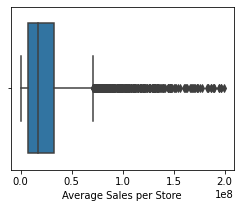

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize = (4,3))
sns.boxplot("Average Sales per Store", data = df_new1)
plt.show();

#이상치 확인

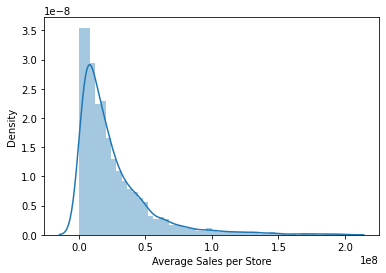

In [ ]:
sns.distplot(df_new1['Average Sales per Store'])

In [ ]:
target = 'Above Average'
#타겟으로 삼을 것 정리

In [ ]:
df_new1.shape

(4957, 36)

In [ ]:
df_new1.to_csv('Seoul Market Edited.csv', index=False)

In [ ]:
train, test = train_test_split(df_new1, test_size = 0.2, stratify = df_new1[target],random_state = 42)
train, val = train_test_split(train, test_size = 0.2, stratify = train[target],random_state = 42)
print("train set:", train.shape)
print("val set:", val.shape)
print("test set:", test.shape)
#train, test, validation으로 데이터를 분할

train set: (3172, 36)
val set: (793, 36)
test set: (992, 36)


In [ ]:
features = ['Name of C/A', 'Industry Code Name',
       'Monday S/R', 'Tuesday S/R',
       'Wednesday S/R', 'Thursday S/R', 'Friday S/R', 'Saturday S/R',
       'Sunday S/R', '00-06AM S/R', '06-11AM S/R', '11-02PM S/R',
       '02-05PM S/R', '05-09PM S/R', '09-00AM S/R', 'Male S/R', 'Female S/R',
       'S/R of 10s', 'S/R of 20s', 'S/R of 30s', 'S/R of 40s', 'S/R of 50s',
       'S/R of over 60s', 'Number of Stores', 
      'Total Business pop',
       'Monthly Income', 'Total Expenditure', 'Total Living pop',
       'Total Settled pop']
#특성 별도 정리

In [ ]:
X_train = train[features]
X_test = test[features]
X_val = val[features]
y_train = train[target]
y_test = test[target]
y_val = val[target]

In [ ]:
base = y_train.mode()[0]
baseline = len(y_train)*[base]
baseline_acc = accuracy_score(y_train, baseline)
print(f'기준모델의 정확도는 {baseline_acc.round(3)} 입니다')
#기준모델 정확도 확인

기준모델의 정확도는 0.688 입니다


In [ ]:
from sklearn.tree import DecisionTreeClassifier
pipe_dt = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    DecisionTreeClassifier(random_state=1, criterion="entropy"),
)
pipe_dt.fit(X_train, y_train)

print("훈련 정확도: ", pipe_dt.score(X_train, y_train))
print("검증 정확도: ", pipe_dt.score(X_val, y_val))

y_pred = pipe_dt.predict(X_test)
#디시즌트리 정확도 확인

훈련 정확도:  1.0
검증 정확도:  0.6645649432534678


In [ ]:
from sklearn.metrics import classification_report

y_pred = pipe_dt.predict(X_test)
print(classification_report(y_test, y_pred))
#평가 지표 확인

              precision    recall  f1-score   support

           0       0.76      0.74      0.75       682
           1       0.46      0.49      0.47       310

    accuracy                           0.66       992
   macro avg       0.61      0.61      0.61       992
weighted avg       0.67      0.66      0.66       992



In [ ]:
pipe_rf = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(max_depth = 10, random_state=42, oob_score=True, n_jobs=-1),
)

pipe_rf.fit(X_train, y_train)
print("훈련 정확도: ", pipe_rf.score(X_train, y_train))
print("검증 정확도: ", pipe_rf.score(X_val, y_val))
#랜덤포레스트 훈련, 검증 정확도 확인

훈련 정확도:  0.9401008827238335
검증 정확도:  0.755359394703657


In [ ]:
pipe_rf.named_steps["randomforestclassifier"].oob_score_

0.7604035308953342

In [ ]:
y_pred = pipe_rf.predict(X_test)
print(classification_report(y_test, y_pred))
#평가 지표 확인

              precision    recall  f1-score   support

           0       0.80      0.92      0.86       682
           1       0.74      0.50      0.60       310

    accuracy                           0.79       992
   macro avg       0.77      0.71      0.73       992
weighted avg       0.78      0.79      0.78       992



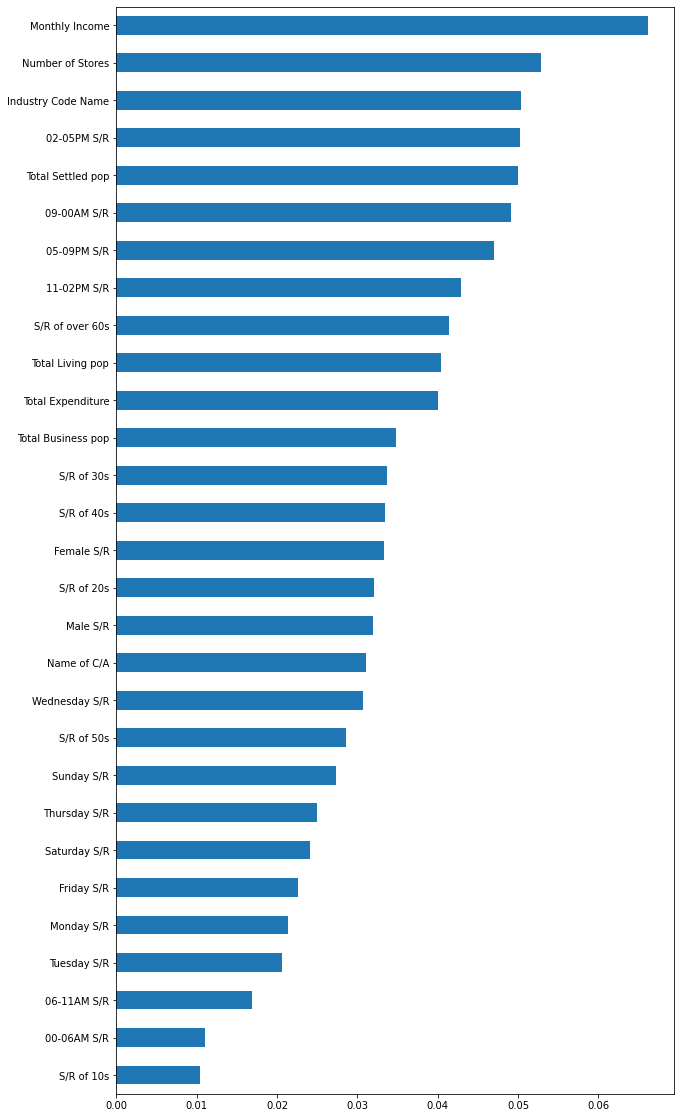

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

model_rf = pipe_rf.named_steps['randomforestclassifier']
importances = pd.Series(model_rf.feature_importances_, X_train.columns)
plt.figure(figsize=(10, 20))
importances.sort_values().plot.barh();

In [ ]:
from scipy.stats.distributions import uniform

params = {
    "simpleimputer__strategy": ["median", "mean"],
    "xgbclassifier__max_depth": [2, 4, 6],
    "xgbclassifier__min_child_weight": [2, 4, 8],
    "xgbclassifier__colsample_bytree": uniform(
        loc=0.5, scale=0.5
    ),  # 0.5 ~ 1 사이의 uniform 분포로 범위를 지정해 줍니다.
}
#랜더마이즈드서치 해보기

In [ ]:
from xgboost import XGBClassifier
pipe = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy="mean"),
    XGBClassifier(
        objective="binary:logistic",
        eval_metric="auc",
        n_estimators=200,
        random_state=42,
        n_jobs=-1,
        max_depth=6,
        min_child_weight=4,
        colsample_bytree=0.79,
        learning_rate=0.1,
        use_label_encoder=False,
        scale_pos_weight = 1
    ),
)

pipe.fit(X_train, y_train)
pipe.score(X_val, y_val)
#xgbclassifier 시도해보고 스코어 확인

0.7704918032786885

In [ ]:
y_pred = pipe.predict(X_test)

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))
#평가 지표 확인

              precision    recall  f1-score   support

           0       0.82      0.90      0.86       682
           1       0.72      0.57      0.63       310

    accuracy                           0.80       992
   macro avg       0.77      0.73      0.75       992
weighted avg       0.79      0.80      0.79       992



In [ ]:
!pip3 install hyperopt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from category_encoders import OrdinalEncoder
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
from sklearn.pipeline import make_pipeline
pipe = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy="median"),
    XGBClassifier(
        objective="binary:logistic",
        eval_metric="error",
        n_estimators=200,
        random_state=42,
        n_jobs=-1,
        learning_rate=0.1,
        use_label_encoder=False,
    ),
)


In [ ]:
from hyperopt import hp

params = {
    "simpleimputer__strategy": hp.choice("strategy", ["median", "mean"]),
    "xgbclassifier__max_depth": hp.quniform("max_depth", 2, 10, 2),
    "xgbclassifier__min_child_weight": hp.quniform("min_child_weight", 2, 10, 2),
    "xgbclassifier__colsample_bytree": hp.uniform("colsample_bytree", 0.5, 1.0),
}
#하이퍼옵트

In [ ]:
from hyperopt import fmin, tpe, Trials, STATUS_OK
from sklearn.model_selection import cross_val_score
import numpy as np


def get_pipe(params):
    params["xgbclassifier__max_depth"] = int(
        params["xgbclassifier__max_depth"]
    )  # max_depth는 정수형으로 변환해 줍니다.
    pipe = make_pipeline(
        OrdinalEncoder(),
        SimpleImputer(strategy="median"),
        XGBClassifier(
            objective="binary:logistic",
            eval_metric="error",
            n_estimators=200,
            random_state=42,
            n_jobs=-1,
            learning_rate=0.1,
            use_label_encoder=False,
        ),
    )
    pipe = pipe.set_params(**params)
    return pipe


def fit_and_eval(params):
    pipe = get_pipe(params) 
    score = cross_val_score(pipe, X_train, y_train, cv=3, scoring="roc_auc")
    avg_cv_score = np.mean(score)

    return {"loss": -avg_cv_score, "status": STATUS_OK}


trials = (
    Trials()
)  

best_params = fmin(
    fn=fit_and_eval, trials=trials, space=params, algo=tpe.suggest, max_evals=10
) 

100%|██████████| 10/10 [00:41<00:00,  4.16s/it, best loss: -0.8227419703176237]


In [ ]:
print("최적 하이퍼파라미터: ", trials.best_trial["misc"]["vals"])
print("최적 AUC: ", -trials.best_trial["result"]["loss"])
#최적 하이퍼파라미터, AUC 확인

최적 하이퍼파라미터:  {'colsample_bytree': [0.5850259315280395], 'max_depth': [10.0], 'min_child_weight': [10.0], 'strategy': [1]}
최적 AUC:  0.8227419703176237


In [ ]:
pipe = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy="median"),
    XGBClassifier(
        objective="binary:logistic",
        eval_metric="auc",
        n_estimators=200,
        random_state=42,
        n_jobs=-1,
        max_depth=6,
        min_child_weight=8,
        colsample_bytree=0.6,
        learning_rate=0.1,
        subsample = 0.8,
        use_label_encoder=False,
        scale_pos_weight = 1
    ),
)

pipe.fit(X_train, y_train)
pipe.score(X_val, y_val)
y_pred = pipe.predict(X_test)

In [ ]:
y_pred = pipe.predict(X_test)

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.87      0.85       682
           1       0.68      0.60      0.64       310

    accuracy                           0.79       992
   macro avg       0.75      0.74      0.74       992
weighted avg       0.78      0.79      0.78       992



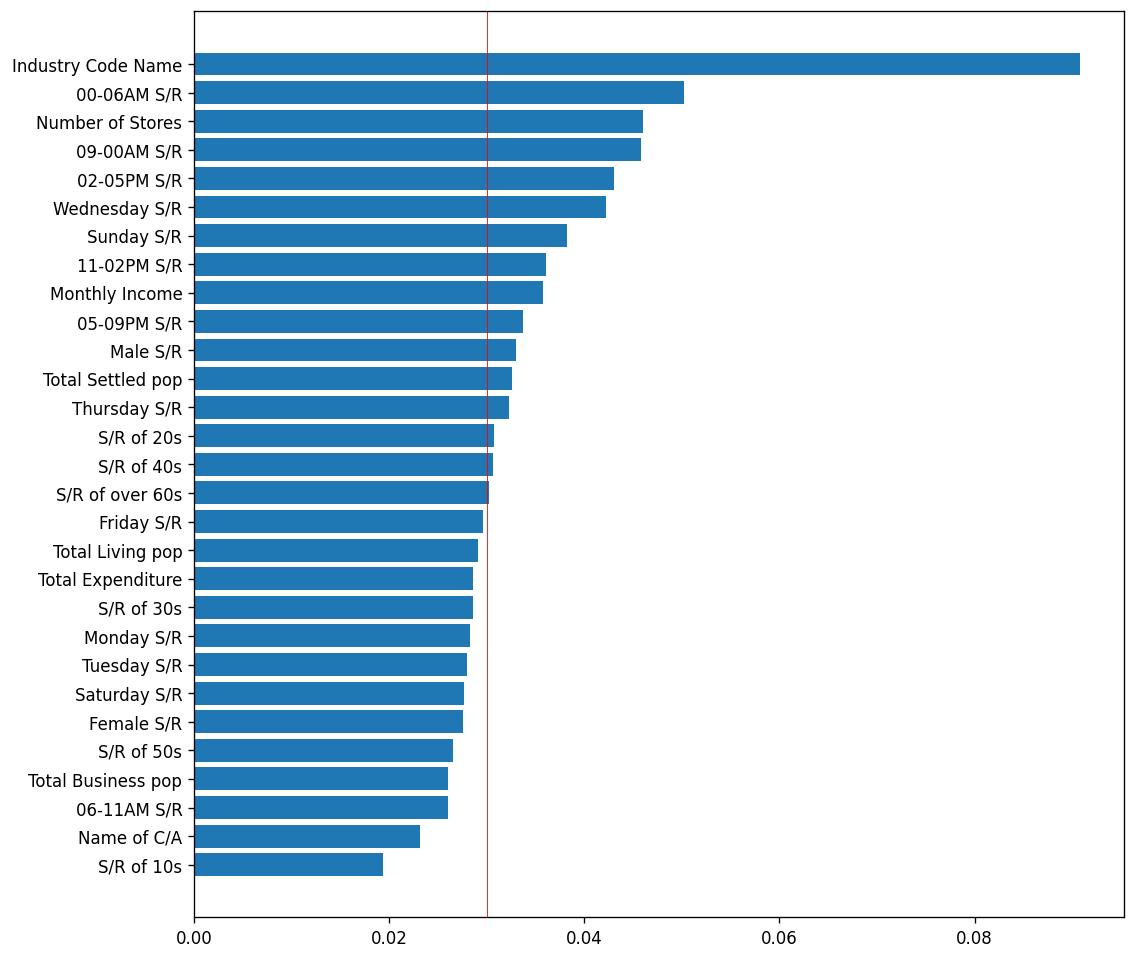

In [ ]:
import matplotlib.pyplot as plt

feature_importances = list(
    zip(X_train.columns, pipe.named_steps["xgbclassifier"].feature_importances_)
)
feature_importances = sorted(feature_importances, key=lambda x: x[1], reverse=True)

plt.figure(figsize=(10, 10), dpi=120)

plt.barh(*list(zip(*feature_importances[::-1])), alpha = 1)
plt.axvline(0.03, color="red", linewidth=0.5);

#특성 중요도 파악

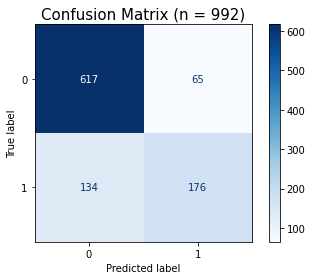

AUC: 0.8246239712420773


In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

plot_confusion_matrix(pipe, X_test, y_test, cmap=plt.cm.Blues)
plt.title(f"Confusion Matrix (n = {len(y_test)})", fontsize=15)
plt.show()

y_pred_proba = pipe.predict_proba(X_test)[:, 1]
print("AUC:", roc_auc_score(y_test, y_pred_proba))

#confusion matrix 확인

In [ ]:
pipe = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy="median"),
    XGBClassifier(
        objective="binary:logistic",
        eval_metric="auc",
        n_estimators=200,
        random_state=42,
        n_jobs=-1,
        max_depth=6,
        min_child_weight=8,
        colsample_bytree=0.6,
        learning_rate=0.1,
        subsample = 0.8,
        use_label_encoder=False,
        scale_pos_weight = 1
    ),
)

pipe.fit(X_train, y_train)
pipe.score(X_val, y_val)
y_pred = pipe.predict(X_test)

In [ ]:
score = pipe.score(X_test, y_test)
pi = pd.Series(dtype=float)

n_iter = 10  

for feature in features:
    X_test_permed = X_test.copy()

    scores_permutated = []
    for _ in range(n_iter):
        X_test_permed[feature] = np.random.permutation(X_test_permed[feature])
        scores_permutated.append(pipe.score(X_test_permed, y_test))
    avg_score_permutated = np.mean(scores_permutated)
    print(f"Perm {feature} :: 검증 정확도 {avg_score_permutated:.6f}")

    pi[feature] = score - avg_score_permutated

Perm Name of C/A :: 검증 정확도 0.799194
Perm Industry Code Name :: 검증 정확도 0.776512
Perm Monday S/R :: 검증 정확도 0.792137
Perm Tuesday S/R :: 검증 정확도 0.794556
Perm Wednesday S/R :: 검증 정확도 0.789617
Perm Thursday S/R :: 검증 정확도 0.790323
Perm Friday S/R :: 검증 정확도 0.788609
Perm Saturday S/R :: 검증 정확도 0.795565
Perm Sunday S/R :: 검증 정확도 0.792944
Perm 00-06AM S/R :: 검증 정확도 0.793851
Perm 06-11AM S/R :: 검증 정확도 0.799395
Perm 11-02PM S/R :: 검증 정확도 0.791734
Perm 02-05PM S/R :: 검증 정확도 0.778226
Perm 05-09PM S/R :: 검증 정확도 0.786794
Perm 09-00AM S/R :: 검증 정확도 0.786391
Perm Male S/R :: 검증 정확도 0.792339
Perm Female S/R :: 검증 정확도 0.794859
Perm S/R of 10s :: 검증 정확도 0.797480
Perm S/R of 20s :: 검증 정확도 0.787298
Perm S/R of 30s :: 검증 정확도 0.793347
Perm S/R of 40s :: 검증 정확도 0.788810
Perm S/R of 50s :: 검증 정확도 0.792944
Perm S/R of over 60s :: 검증 정확도 0.793044
Perm Number of Stores :: 검증 정확도 0.771875
Perm Total Business pop :: 검증 정확도 0.790726
Perm Monthly Income :: 검증 정확도 0.779234
Perm Total Expenditure :: 검증 정확도 0.789617
Perm

Text(0.5, 1.0, 'Permutation Importance')

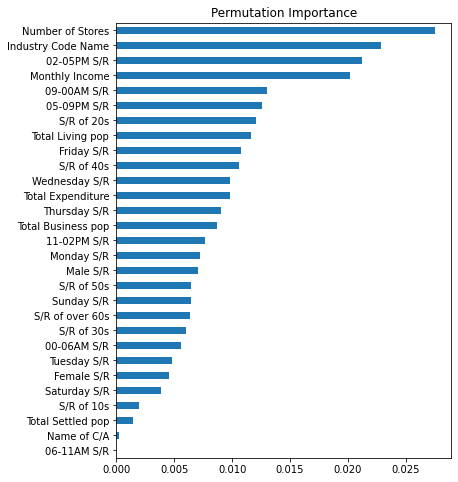

In [ ]:
pi.sort_values().plot.barh(figsize = (6,8))
plt.title("Permutation Importance")
#순열 중요도 파악

In [ ]:
pip install pdpbox

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from category_encoders import OrdinalEncoder
from sklearn.metrics import classification_report, roc_auc_score
from xgboost import XGBClassifier

encoder = OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train)  # 학습데이터
X_val_encoded = encoder.transform(X_val)  # 검증데이터

boosting = XGBClassifier(
    n_estimators=200,
    n_jobs=-1,
    eval_metric="auc",
    objective="binary:logistic",  # default
    learning_rate=0.1,
    max_depth=6,
    min_child_weight=8,
    use_label_encoder=False,
    subsample=0.8,
    scale_pos_weight = 1,
    colsample_bytree=0.6,

)

eval_set = [(X_train_encoded, y_train), (X_val_encoded, y_val)]

boosting.fit(X_train_encoded, y_train, eval_set=eval_set, early_stopping_rounds=50)

[0]	validation_0-auc:0.797694	validation_1-auc:0.746882
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 50 rounds.
[1]	validation_0-auc:0.823321	validation_1-auc:0.758546
[2]	validation_0-auc:0.840599	validation_1-auc:0.758427
[3]	validation_0-auc:0.853953	validation_1-auc:0.77005
[4]	validation_0-auc:0.860266	validation_1-auc:0.775993
[5]	validation_0-auc:0.866243	validation_1-auc:0.779964
[6]	validation_0-auc:0.871836	validation_1-auc:0.782648
[7]	validation_0-auc:0.876155	validation_1-auc:0.784795
[8]	validation_0-auc:0.882365	validation_1-auc:0.789259
[9]	validation_0-auc:0.884412	validation_1-auc:0.790108
[10]	validation_0-auc:0.886899	validation_1-auc:0.790004
[11]	validation_0-auc:0.889938	validation_1-auc:0.789666
[12]	validation_0-auc:0.891067	validation_1-auc:0.789414
[13]	validation_0-auc:0.891838	validation_1-auc:0.788584
[14]	validation_0-auc:0.893686	validation_1-auc:0.789058

XGBClassifier(colsample_bytree=0.6, eval_metric='auc', max_depth=6,
              min_child_weight=8, n_estimators=200, n_jobs=-1, subsample=0.8,
              use_label_encoder=False)

In [ ]:
X_train.columns

Index(['Name of C/A', 'Industry Code Name', 'Monday S/R', 'Tuesday S/R',
       'Wednesday S/R', 'Thursday S/R', 'Friday S/R', 'Saturday S/R',
       'Sunday S/R', '00-06AM S/R', '06-11AM S/R', '11-02PM S/R',
       '02-05PM S/R', '05-09PM S/R', '09-00AM S/R', 'Male S/R', 'Female S/R',
       'S/R of 10s', 'S/R of 20s', 'S/R of 30s', 'S/R of 40s', 'S/R of 50s',
       'S/R of over 60s', 'Number of Stores', 'Total Business pop',
       'Monthly Income', 'Total Expenditure', 'Total Living pop',
       'Total Settled pop'],
      dtype='object')

In [ ]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

In [ ]:
mappings = encoder.mapping
print(mappings)
#맵핑 확인

[{'col': 'Name of C/A', 'mapping': 광나루역 1번         1
개화산역 1번         2
자양한강도서관         3
삼선동주민센터         4
서울대입구역 8번       5
             ... 
목동문화체육센터     1000
백석중학교        1001
신정네거리역 2번    1002
대방역 4번       1003
NaN            -2
Length: 1004, dtype: int64, 'data_type': dtype('O')}, {'col': 'Industry Code Name', 'mapping': 치킨전문점      1
중식음식점      2
호프-간이주점    3
커피-음료      4
한식음식점      5
분식전문점      6
패스트푸드점     7
일식음식점      8
양식음식점      9
NaN       -2
dtype: int64, 'data_type': dtype('O')}]


(<Figure size 540x684 with 3 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f9819a75250>,
  'pdp_inter_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f9819446ed0>})

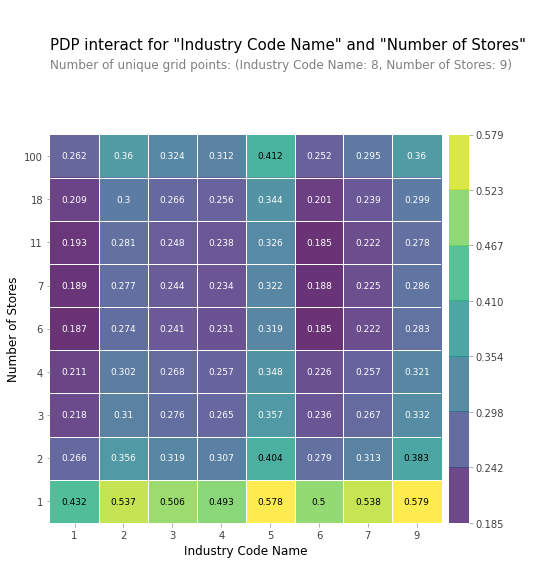

In [ ]:
target_features = ['Industry Code Name', 'Number of Stores']

interaction = pdp_interact(
    model=boosting,
    dataset=X_val_encoded,
    model_features=X_val.columns,
    features=target_features,
)
pdp_interact_plot(interaction, plot_type="grid", feature_names=target_features)

#특성중요도에서 높았던 industry code name과 name of stores의 PDP interact 확인

(<Figure size 540x684 with 3 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f98080bbd10>,
  'pdp_inter_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f981944e510>})

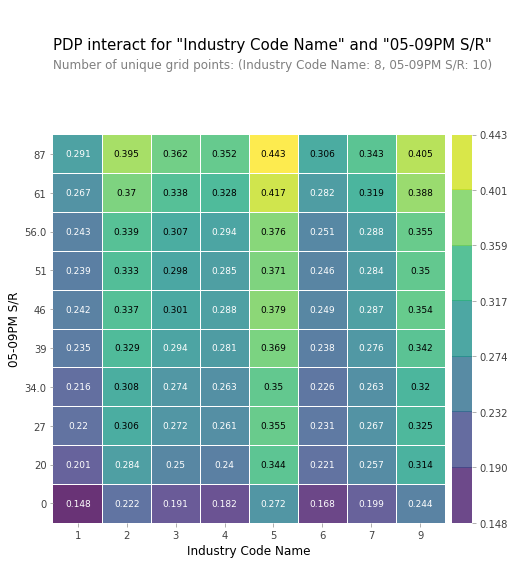

In [ ]:
target_features = ['Industry Code Name', '05-09PM S/R']

interaction = pdp_interact(
    model=boosting,
    dataset=X_val_encoded,
    model_features=X_val.columns,
    features=target_features,
)
pdp_interact_plot(interaction, plot_type="grid", feature_names=target_features)

#Industry code name과 05-09pm PDP interact 확인

(<Figure size 540x684 with 3 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f981ecea390>,
  'pdp_inter_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f981dd0c850>})

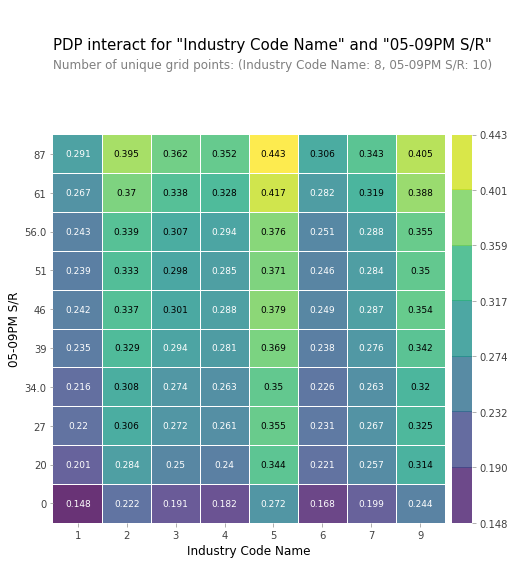

In [ ]:
target_features = ['Industry Code Name', '05-09PM S/R']

interaction = pdp_interact(
    model=boosting,
    dataset=X_val_encoded,
    model_features=X_val.columns,
    features=target_features,
)
pdp_interact_plot(interaction, plot_type="grid", feature_names=target_features)

In [ ]:
import matplotlib.pyplot as plt

plt.rcParams["figure.dpi"] = 144

In [ ]:
train['Monthly Income'].describe()

count    3.168000e+03
mean     2.721062e+06
std      5.917281e+05
min      6.491330e+05
25%      2.358335e+06
50%      2.540629e+06
75%      2.882060e+06
max      6.369714e+06
Name: Monthly Income, dtype: float64

In [ ]:
X_train['Total Expenditure'].describe()

count    3.160000e+03
mean     1.793955e+09
std      1.478083e+09
min      1.543871e+06
25%      7.015218e+08
50%      1.410195e+09
75%      2.402968e+09
max      1.186086e+10
Name: Total Expenditure, dtype: float64

In [ ]:
def get_ice_plot_data(data, data_index, target_feature, target_feature_range):
    one_datapoint = data.iloc[[data_index]].copy()
    results = []

    for target_value in target_feature_range:
        one_datapoint[target_feature] = target_value
        one_datapoint_pred_proba = boosting.predict_proba(one_datapoint)[:, 1]
        results.append(one_datapoint_pred_proba.item())
    results = np.array(results)
    return target_feature_range, results - results[0]

In [ ]:
from tqdm import tqdm

target_feature =   'Monthly Income'
target_feature_range = [0, 500000, 1000000, 1500000, 2000000]

all_ice_plot_data = []

for data_index in tqdm(range(len(X_val_encoded))):
    all_ice_plot_data.append(
        get_ice_plot_data(
            X_val_encoded, data_index, target_feature, target_feature_range
        )[1]
    )

100%|██████████| 793/793 [00:04<00:00, 159.17it/s]


(<Figure size 2160x1368 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f98087ffbd0>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f9817206990>})

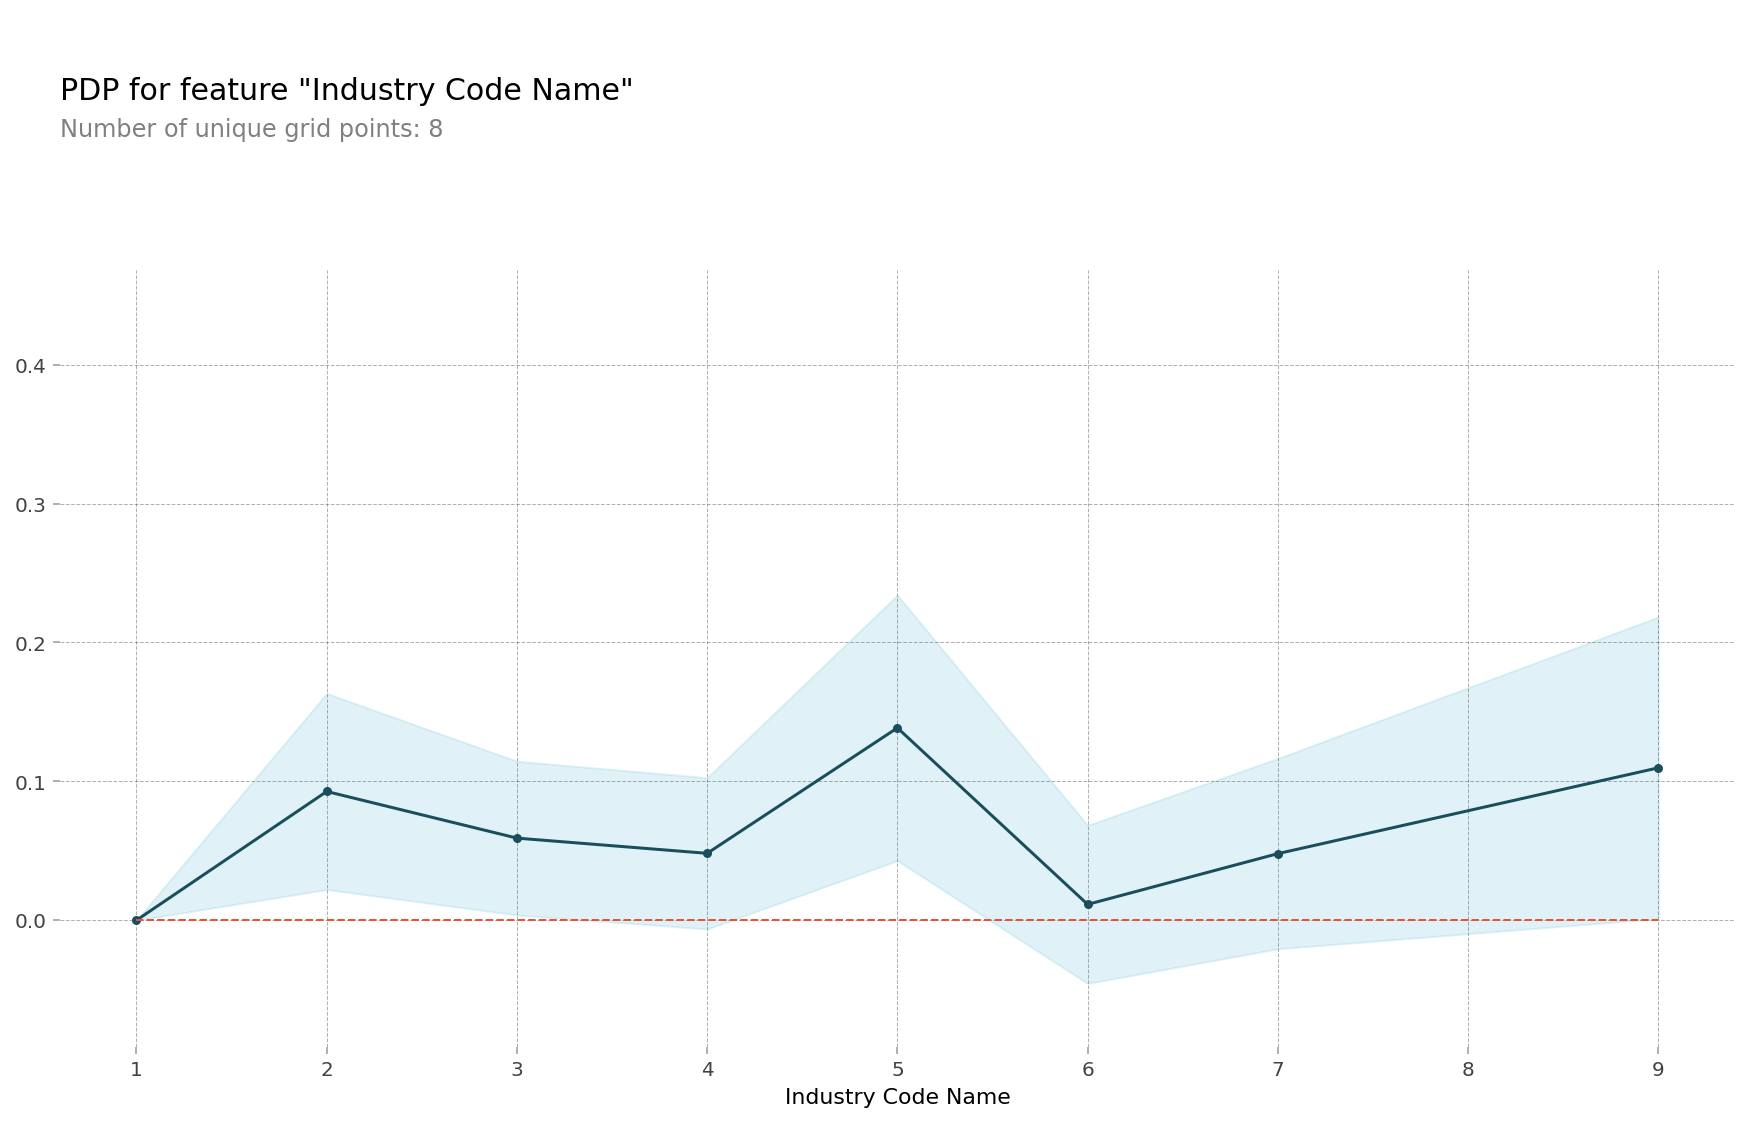

In [ ]:
from pdpbox.pdp import pdp_isolate, pdp_plot

target_feature = "Industry Code Name"

isolated = pdp_isolate(
    model=boosting,
    dataset=X_val_encoded,
    model_features=X_val.columns,
    feature=target_feature,
    grid_type="percentile",  # default = 'percentile', or 'equal'
    num_grid_points=10,  # default = 10
)
pdp_plot(isolated, feature_name=target_feature)

#industry code name의 특성 분석

In [ ]:
condition1 =df_new1['Total Business pop'] >900
condition2= df_new1['Monthly Income'] > 5000000
sorted = df_new1[condition1 & condition2]
sorted2 = sorted[['Name of C/A', 'Industry Code Name', 'Number of Stores','Monthly Income', 'Total Business pop', 'Above Average']]
sorted2.sort_values(by = 'Monthly Income', ascending = False)

#경쟁 점포가 없고, 월 소득 500만원 이상, 직장 인구수 900명 이상의 상권 리스트를 추천 리스트로 정리

,Name of C/A,Industry Code Name,Number of Stores,Monthly Income,Total Business pop,Above Average
3841,청담초등학교,양식음식점,2.0,6473963.0,2996.0,1
3688,잠실나루역,분식전문점,4.0,6025078.0,9608.0,0
3689,잠실나루역,한식음식점,4.0,6025078.0,9608.0,1
7917,유엔빌리지길,양식음식점,5.0,5729183.0,12646.0,1
4036,서초소방서,커피-음료,2.0,5702163.0,1505.0,0
7079,길상사,한식음식점,7.0,5608226.0,13811.0,1
7078,길상사,양식음식점,1.0,5608226.0,13811.0,1
7077,길상사,커피-음료,1.0,5608226.0,13811.0,1
3797,삼성중앙역 5번,양식음식점,5.0,5591064.0,1246.0,0
4040,서래초등학교,커피-음료,4.0,5553821.0,2807.0,1
